In [3]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load raw data
df = pd.read_csv('../data/raw/telco_churn.csv')

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values safely
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Drop customer ID
df = df.drop('customerID', axis=1)

# Encode target variable
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature engineering
df_encoded['AvgMonthlyCharge'] = df_encoded['TotalCharges'] / (df_encoded['tenure'] + 1)
df_encoded['HighTenure'] = (df_encoded['tenure'] > 24).astype(int)


In [5]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(5634, 32) (1409, 32)


In [6]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_sm.value_counts())


After SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


In [9]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train_sm)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]


In [10]:
print("Logistic Regression")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1 Score :", f1_score(y_test, y_pred_lr))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_lr))


Logistic Regression
Accuracy : 0.7608232789212207
Precision: 0.5454545454545454
Recall   : 0.5935828877005348
F1 Score : 0.5685019206145967
ROC-AUC  : 0.8190033325583197


In [11]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train_sm, y_train_sm)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


In [12]:
print("Random Forest")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_rf))


Random Forest
Accuracy : 0.7672107877927609
Precision: 0.5586734693877551
Recall   : 0.5855614973262032
F1 Score : 0.5718015665796344
ROC-AUC  : 0.816934046345811


In [13]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train_sm, y_train_sm)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]


In [14]:
print("XGBoost")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall   :", recall_score(y_test, y_pred_xgb))
print("F1 Score :", f1_score(y_test, y_pred_xgb))
print("ROC-AUC  :", roc_auc_score(y_test, y_prob_xgb))


XGBoost
Accuracy : 0.7814052519517388
Precision: 0.582089552238806
Recall   : 0.6256684491978609
F1 Score : 0.6030927835051546
ROC-AUC  : 0.8249451032059728


In [15]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})

results


,Model,Accuracy,Recall,ROC-AUC
0,Logistic Regression,0.760823,0.593583,0.819003
1,Random Forest,0.767211,0.585561,0.816934
2,XGBoost,0.781405,0.625668,0.824945


### Model Insights
- Logistic Regression provides a strong baseline
- Random Forest captures non-linear churn patterns
- XGBoost delivers the best performance overall
- Recall is prioritized to minimize missed churn customers


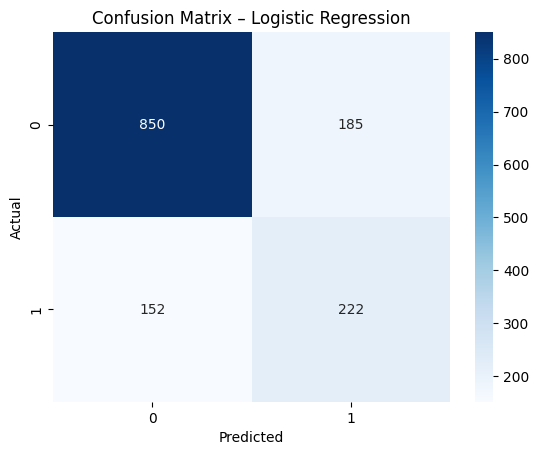

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


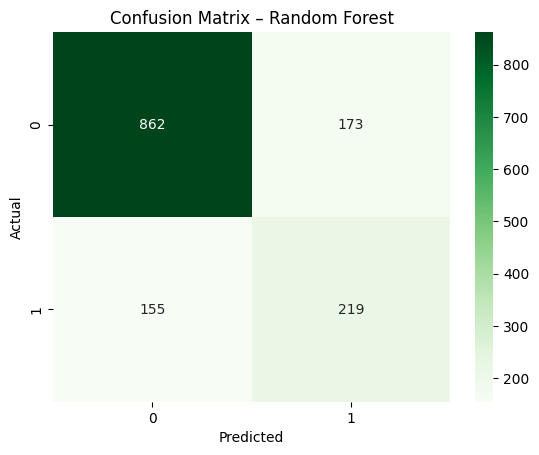

In [17]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix – Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


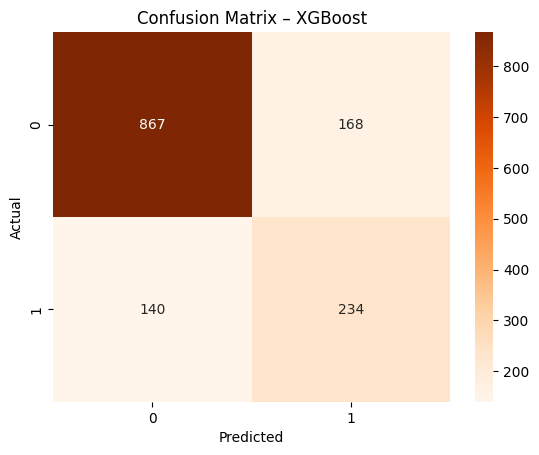

In [18]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix – XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


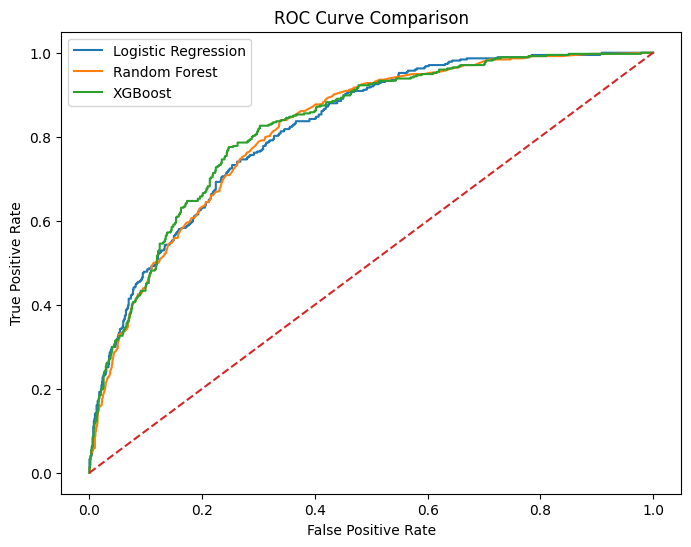

In [19]:
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [20]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.head(10)


,Feature,Importance
3,TotalCharges,0.129401
1,tenure,0.113327
30,AvgMonthlyCharge,0.106856
2,MonthlyCharges,0.101815
28,PaymentMethod_Electronic check,0.100585
10,InternetService_Fiber optic,0.055485
26,PaperlessBilling_Yes,0.044236
31,HighTenure,0.038070
25,Contract_Two year,0.036394
9,MultipleLines_Yes,0.021753


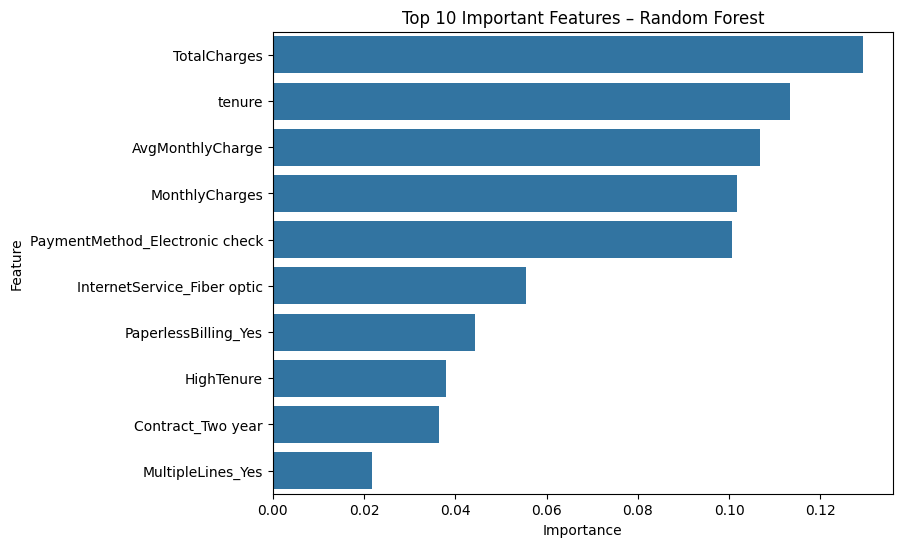

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance.head(10)
)
plt.title('Top 10 Important Features – Random Forest')
plt.show()


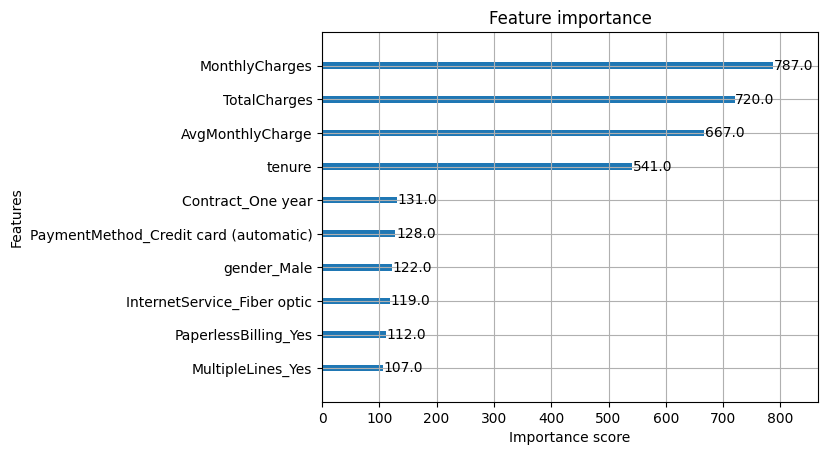

In [22]:
from xgboost import plot_importance

plot_importance(xgb, max_num_features=10)
plt.show()


### Business Insights from Feature Importance
- Month-to-month contracts significantly increase churn risk
- Low tenure customers are highly likely to churn
- Higher monthly charges correlate with churn
- Customers using electronic check payments show higher churn


In [23]:
custom_threshold = 0.4
y_pred_custom = (y_prob_xgb >= custom_threshold).astype(int)

print("Recall with custom threshold:",
      recall_score(y_test, y_pred_custom))


Recall with custom threshold: 0.6818181818181818


In [24]:
import joblib

joblib.dump(xgb, '../models/churn_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')


FileNotFoundError: [Errno 2] No such file or directory: '../models/churn_model.pkl'

In [25]:
os.listdir('../models')


NameError: name 'os' is not defined